**Import statements**

In [38]:
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt
from environments import EnvSetTarget
from environments import EnvChaseTarget
import math

**Bellman Solver that can give us the exact solution for agent 1**

In [8]:
class BellmanSolver:

    def __init__(self,max_darts
                ,max_lives
                ,num_actions
                ,success_prob={0: 0.95, 1: 0.88, 2: 0.80, 3: 0.6}
                ,action_max_reward = {0: 1, 1: 2, 2: 4, 3: 6}):
        """
        :param max_darts:
        :param max_lives:
        :param num_actions:
        :param success_prob
        :param action_max_reward 

        """
        #set the parameters of the env
        self.max_darts = max_darts
        self.max_lives = max_lives
        self.num_actions = num_actions

        #initialize all the arrays and values
        self.total_states = (max_darts + 1) * (max_lives + 1)  # since two features
        self.T = np.zeros((self.total_states, num_actions, self.total_states))  # state transition matrix(P(s'|s,a))
        # now T is a 3d matrix we will reshape it later for calculation purposes
        self.pi = np.ones((self.total_states, num_actions)) / num_actions  # equiprobable policy
        self.V = np.zeros((self.total_states, 1))  # V values
        self.R = np.zeros((self.total_states, num_actions))  # expected reward r(s,a)
        self.success_prob = {0: 0.95, 1: 0.88, 2: 0.80, 3: 0.6}
        self.action_max_reward = {0: 1, 1: 2, 2: 4, 3: 6}
        self.action_expected_reward = {action: action_max_reward[action] * success_prob[action]
                                  for action in range(num_actions)}
        
        self.initialize_T() #initialize the Transition matrix
        

    def initialize_T(self):
        for action in range(self.num_actions):
            print(action)
            for state in range(self.total_states):
                time_elapsed = state // (self.max_lives + 1)
                lives_lost = state % (self.max_lives + 1)
                if lives_lost == self.max_lives or time_elapsed == self.max_darts:  # if state i terminal
                    continue
                if lives_lost > time_elapsed:  # can't loose more lives than time steps
                    continue
                next_time_elapsed = time_elapsed + 1
                next_state_success = next_time_elapsed * (self.max_lives + 1) + lives_lost
                next_state_failure = next_time_elapsed * (self.max_lives + 1) + (lives_lost + 1)
                self.T[state, action, next_state_success] = self.success_prob[action]
                self.T[state, action, next_state_failure] = 1 - self.success_prob[action]
                self.R[state, action] = self.action_expected_reward[action]

    # calculate T_pi as given in
    # https://www.cs.cmu.edu/~katef/DeepRLControlCourse/lectures/lecture3_mdp_planning.pdf
    def calc_T_pi(self):

        self.T = \
            self.T.reshape((self.total_states * self.num_actions, self.total_states))  # change shape to (s*a,s)
        self.pi = self.pi.reshape((self.total_states * self.num_actions, 1))  # reshape to (s*a,1)
        T_pi = self.pi * self.T
        T_pi.shape
        T_pi = T_pi.reshape((self.total_states, self.num_actions, self.total_states))
        T_pi = np.sum(T_pi, axis=1)
        self.T = self.T.reshape((self.total_states, self.num_actions, self.total_states))  # change shape to (s,a,s)
        self.pi = self.pi.reshape((self.total_states, self.num_actions))  # reshape to (s,a)
        T_pi.shape
        return T_pi

    # R_pi
    def calc_R_pi(self):
        self.pi = self.pi.reshape((self.total_states, self.num_actions))  # reshape to (s,a)
        R_pi = np.sum(self.pi * self.R, axis=1)
        R_pi.shape
        return R_pi

    def solve(self,gamma):
        # update policy pi
        # for every valid state
        # for all actions check (prob_success(r+v(next_success_state) + 1-prob-success(0+v(next_state_failure)))
        while(True):
            T_pi = self.calc_T_pi()
            R_pi = self.calc_R_pi()
            I = np.identity(self.total_states)
            old_V = self.V
            Q = np.zeros((self.max_darts + 1, self.max_lives + 1, self.num_actions))
            self.V = np.dot(np.linalg.inv(I - gamma * T_pi), R_pi)
            for state in range(self.total_states):
                time_elapsed = state // (self.max_lives + 1)
                lives_lost = state % (self.max_lives + 1)
                if lives_lost == self.max_lives or time_elapsed == self.max_darts:  # if state i terminal
                    continue
                if lives_lost > time_elapsed:
                    continue
                next_time_elapsed = time_elapsed + 1
                next_state_success = next_time_elapsed * (self.max_lives + 1) + lives_lost
                next_state_failure = next_time_elapsed * (self.max_lives + 1) + (lives_lost + 1)
                max_G = 0
                max_action = 0
                for action in range(self.num_actions):
                    G = \
                        self.success_prob[action] * (self.action_max_reward[action]
                                                     + self.V[next_state_success]) \
                    + (1 - self.success_prob[action]) * (0 + self.V[next_state_failure])
                    Q[time_elapsed, lives_lost, action] = G
                    if max_G < G:
                        max_G = G
                        max_action = action
                self.pi[state, :] = 0
                self.pi[state, max_action] = 1
            print(np.max(np.abs(old_V - self.V)))
            if np.max(np.abs(old_V - self.V)) < 0.0001:
                break
        return Q


In [9]:
def Q_learning(env,num_episodes,Q,alpha,epsilon,gamma,lamb):
    """
    :param : env
    :param : num_episodes 
    :param : Q - 2D array of values for state action pairs
    :param : alpha - learning rate
    :param : epsilon - explore-exploit trade-off parameter
    :param : gamma - discount factor
    :param : lamb - eligibility trace decay factor
    """
    l = []    #this list will store the scores achieved in all episodes
    for _ in range(num_episodes):
        total_score = 0 #at the start of every new episode set total score to 0
        eligibility=np.zeros(Q.shape)#define eligibility
        observation = env.reset()# reset the environment to start
        #last_state = observation#set last state
        r_list = []
        while(True):
             
            Q_old = deepcopy(Q)#make a copy of Q
            x = np.random.binomial(n=1,size=1,p=1-epsilon)#flip a coin with p=1-epsilon
            action = -1
            if x[0] == 1:#exploitation if bernoulli RV = 1
                action = np.argmax(Q[observation[0],observation[1],:])
            else:#exploration
                action = np.random.randint(low=0,high=4)
                eligibility = np.zeros(Q.shape) #set eligibility to 0 as per Watkins

            #store the current state before taking the action
            old_observation = deepcopy(observation)#state s
            ##update the eligibility for the last state action
            eligibility[old_observation[0],old_observation[1],action] += 1
            #take the new action
            observation, reward, done, info = env.step(action)#take action
            #update the score
            total_score += max(reward,0)
            r_list.append(reward)
            """
            Q-learning update step
            """            
            
            #calculate detla
            delta = reward + gamma*np.max(Q[observation[0], observation[1], :]) - Q[
                        old_observation[0], old_observation[1],action]
            #update Q
            Q += alpha * delta * eligibility  
            #decay eligibility
            eligibility *= lamb

            if done:#check if the episode has terminated
                l.append(total_score)#append the score achieved to a list
                break
    #return the list of total scores
    return l

In [10]:
#runner for Q learning
def runQ_learning(max_time_steps, max_lives_lost, 
                  alpha, epsilon, gamma, lamb, 
                  num_episodes, num_decay_batches=5, decay_factor=0.999):
    #create environment
    env = EnvSetTarget(max_time_steps,max_lives_lost)
    #initialize Q
    Q = np.zeros((max_time_steps+1,max_lives_lost+1,len(env.action_space)))
    #initialize var to keep list of running avg
    sum = 0
    l = []
    for _ in range(num_decay_batches):
        epsilon *= decay_factor
        x=Q_learning(env,num_episodes,Q,alpha,epsilon,gamma,lamb)
        #x=double_Q_learning(env,num_episodes,Q1,Q2,alpha,epsilon,gamma)
        for i in range(len(x)):
            sum+=1/(len(l)+i+1) * (x[i]-sum)
            l.append(sum)

    return Q,np.array(l)
    
    

**At first let us solve the problem using the Bellman equations**

In [11]:
b = BellmanSolver(6,2,4)
bellman_Q = b.solve(1)
bellman_V = b.V
bellman_Q = np.reshape(bellman_Q,(7,3,4))
bellman_V = np.reshape(bellman_V,(7,3))

0
1
2
3
12.9555091365
4.87642686353
0.0576
0.0


In [13]:
num_runs = 5
alpha_list = [x/10 for x in range(2,11,2)]
lambda_list = [x/10 for x in range(0,11,2)]
Qlearning_result_dict = {}
doubleQlearning_result_dict = {}

**Obtain results for Q-learning**

Vary the parameters alpha and lambda. 

In [14]:
for alpha in alpha_list: #for all the alphas
    for lamb in lambda_list:#for all the lambdas
        Q_list=[]
        run_avg_list=[]
        V_list=[]
        for _ in range(num_runs):#run lots of episodes
            Q,run_avg = runQ_learning(max_time_steps=6, max_lives_lost=2, 
                              alpha=alpha, epsilon=0.1, gamma=0.99, lamb=lamb, 
                              num_episodes=5000, num_decay_batches=5, decay_factor=1)
            print(Q.shape,run_avg.shape)
            V = np.max(Q,axis=2)#calculate V values
            Q_list.append(Q)#save the Q value estimate
            run_avg_list.append(run_avg)#store the run avg
            V_list.append(V)#save the V values of states
            print(Q.shape,run_avg.shape)
        Q = deepcopy(Q_list[0])
        run_avg = deepcopy(run_avg_list[0])
        V = deepcopy(V_list[0])
        for _ in range(1,num_runs):
            Q+=Q_list[_]
            V+=V_list[_]
            run_avg+=run_avg_list[_]
        #for the alpha and lambda store the avg Q, V and runiing avg
        Qlearning_result_dict[str(alpha)+"_"+str(lamb)] = {"Q":Q/num_runs,
                                                           "V":V/num_runs,
                                                           "run_avg":run_avg/num_runs}
        


(7, 3, 4) (25000,)
(7, 3, 4) (25000,)
(7, 3, 4) (25000,)
(7, 3, 4) (25000,)
(7, 3, 4) (25000,)
(7, 3, 4) (25000,)
(7, 3, 4) (25000,)
(7, 3, 4) (25000,)
(7, 3, 4) (25000,)
(7, 3, 4) (25000,)


In [15]:
#uncomment the follwing cell and run to load and store the results of Q learning
import pickle
#pickle.dump(Qlearning_result_dict,open("Qlearning_result2.p","wb"))
#Qlearning_result_dict = pickle.load(open("Qlearning_result2.p","rb"))

**Plot Q learning performance**

**Plot the Avg score(running avg) per episode against the num of episodes**

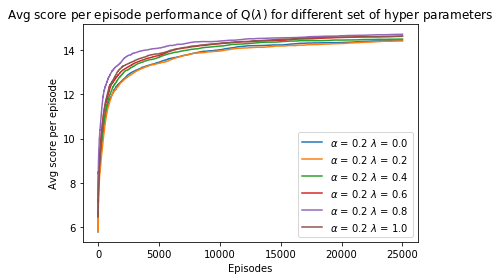

In [21]:
RMSE_Qlearning = [] 
Qlearning_result_dict.keys()
for lamb in lambda_list:
#alpha=0.2
    rmse_curr_list = []
    for alpha in alpha_list:
        curr = Qlearning_result_dict[str(alpha)+"_"+str(lamb)]
        rmse_curr_list.append(np.sqrt(np.mean(np.power(bellman_V - curr["V"],2))))
        if alpha == alpha_list[0]:
            plt.plot(range(curr["run_avg"].size),curr["run_avg"],label=r"$\alpha$ = " + str(alpha)+r" $\lambda$ = "+str(lamb))
        
    RMSE_Qlearning.append(rmse_curr_list)
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Avg score per episode")
plt.title(r"Avg score per episode performance of Q($\lambda$) for different set of hyper parameters")
plt.show()

**Plot the RMSE between V*(s) given by solving Bellman equations and V(s)**

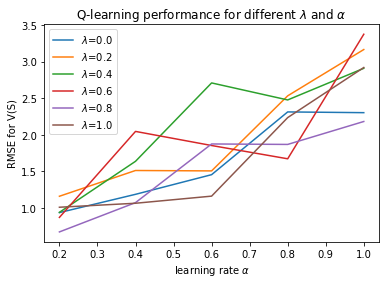

In [23]:
for rmse in RMSE_Qlearning:
    plt.plot(alpha_list,np.array(rmse),label = r"$\lambda$="+str(lambda_list[RMSE_Qlearning.index(rmse)]))
plt.xlabel(r"learning rate $\alpha$")
plt.ylabel("RMSE for V(S)")
plt.title(r"Q-learning performance for different $\lambda$ and $\alpha$")
plt.legend()
plt.show()


**Run this cell to see the effect of alpha parameter when the trace deacy lambda fixed**

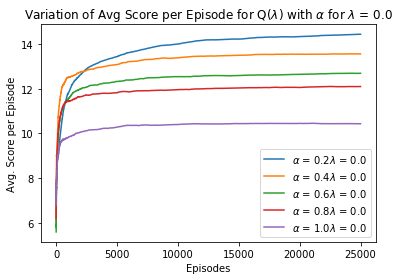

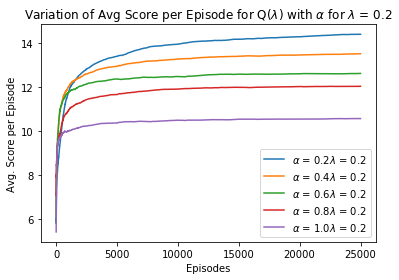

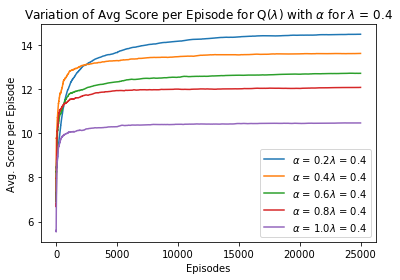

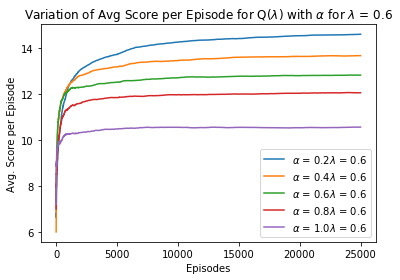

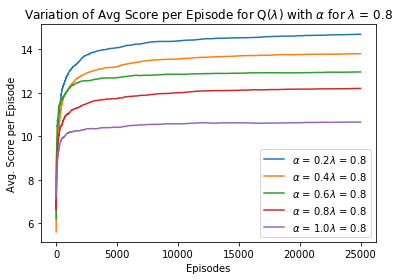

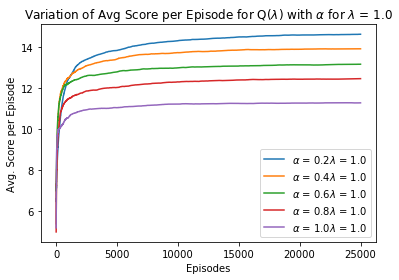

In [32]:
R2 = Qlearning_result_dict
RMSE_Qlearning = [] 
for lamb in lambda_list:
#alpha=0.2
    rmse_curr_list = []
    for alpha in alpha_list:
        curr = R2[str(alpha)+"_"+str(lamb)]
        rmse_curr_list.append(np.sqrt(np.mean(np.power(bellman_V - curr["V"],2))))
        
        plt.plot(range(curr["run_avg"].size),curr["run_avg"],label=r"$\alpha$ = "+str(alpha)+r"$\lambda$ = "+str(lamb))
        #print(curr["run_avg"][-20:])
    RMSE_Qlearning.append(rmse_curr_list)
    plt.legend()
    plt.xlabel("Episodes")
    plt.ylabel("Avg. Score per Episode")
    plt.title(r"Variation of Avg Score per Episode for Q($\lambda$) with $\alpha$ for $\lambda$ = "+str(lamb))
    plt.show()

In [34]:
def  n_step_double_Q_learning(env,num_episodes,Q1,Q2,alpha,epsilon,gamma,n):
    """
    :param : env
    :param : num_episodes 
    :param : Q1 - 2D array of values for state action pairs
    :param : Q2 - 2D array of values for state action pairs
    :param : alpha - learning rate
    :param : epsilon - explore-exploit trade-off parameter
    :param : gamma - discount factor
    :param : lamb - eligibility trace decay factor
    """

    l = [] #this list will store the scores achieved in all episodes
    for _ in range(num_episodes):
        episode_seq = []
        total_score = 0#at the start of every new episode set total score to 0
        observation = env.reset()# reset the environment to start
        r_list = []
        while(True):
            R = np.random.randint(1,3)#random varibale to decide if to use Q1 or Q2
            #input("R="+str(R))
            if R==1: #if random variable R = 1 then choose Q1 to take action
                Q=Q1
                criticQ=Q2
            else: 
                Q=Q2 #if random variable R = 2 then choose Q2 to take action
                criticQ=Q1

            Q_old = deepcopy(Q)#make a copy of Q
            x = np.random.binomial(n=1,size=1,p=1-epsilon)#bernoulli random variable with p=1-epsilon
            action = -1
            if x[0] == 1:#exploitation
                #choose action with highest avg value
                #action = np.argmax(0.5*criticQ[observation[0],observation[1],:]+0.5*Q[observation[0],observation[1],:])
                action = np.argmax(0.5*criticQ[observation[0],observation[1],:]+0.5*Q[observation[0],observation[1],:])
            else:#exploration
                action = np.random.randint(low=0,high=4)
            
            #before taking an action store the current state
            old_observation = deepcopy(observation)
            #take an action
            observation, reward, done, info = env.step(action)#take action
            #store in episode_seq
            episode_seq.append({"S":old_observation,"R":reward,"A":action,"Q1":Q,"Q2":criticQ})
            total_score += max(reward,0)#update the score
            r_list.append(reward)
            """
            Q-learning update step
            """

            #calculate delta by using double Q update
            #delta = reward + gamma*criticQ[observation[0]
            #                               ,observation[1],np.argmax(Q[observation[0], observation[1],:])] 
            #- Q[old_observation[0], old_observation[1],action]

            #Q += alpha * delta * eligibility
            
             
            if done:#if the episode has terminated
                l.append(total_score)#append the score in the episode to list
                break
        #now after the episode is ended update all the states
        for i in range(len(episode_seq)):
            G = 0
            boot_Q2 = 0
            s = episode_seq[i]["S"]
            a = episode_seq[i]["A"]
            q1 = episode_seq[i]["Q1"]
            q2 = episode_seq[i]["Q2"]
            #print(q1.shape," ",q2.shape)
            for j in range(i,min(i+n,len(episode_seq))):
                G += math.pow(gamma,j-i)*episode_seq[j]["R"]            
            if i+n < len(episode_seq): #then bootstrap
                n_s = episode_seq[i+n]["S"]
                #print(n_s)
                n_max_a = np.argmax(q1[n_s[0],n_s[1],:])
                boot_Q2 = q2[n_s[0],n_s[1],n_max_a]
            delta = (G + math.pow(gamma,n)*boot_Q2) - q1[s[0],s[1],a]
            q1[s[0],s[1],a] += alpha*delta
            
            
    return np.array(l)#return the list of scores achieved in all episodes.

In [35]:
def  n_step_doubleweighted_Q_learning(env,num_episodes,Q1,Q2,alpha,epsilon,gamma,n,c):
    """
    :param : env
    :param : num_episodes 
    :param : Q1 - 2D array of values for state action pairs
    :param : Q2 - 2D array of values for state action pairs
    :param : alpha - learning rate
    :param : epsilon - explore-exploit trade-off parameter
    :param : gamma - discount factor
    :param : lamb - eligibility trace decay factor
    """

    l = [] #this list will store the scores achieved in all episodes
    for _ in range(num_episodes):
        episode_seq = []
        total_score = 0#at the start of every new episode set total score to 0
        observation = env.reset()# reset the environment to start
        r_list = []
        while(True):
            R = np.random.randint(1,3)#random varibale to decide if to use Q1 or Q2
            #input("R="+str(R))
            if R==1: #if random variable R = 1 then choose Q1 to take action
                Q=Q1
                criticQ=Q2
            else: 
                Q=Q2 #if random variable R = 2 then choose Q2 to take action
                criticQ=Q1

            Q_old = deepcopy(Q)#make a copy of Q
            x = np.random.binomial(n=1,size=1,p=1-epsilon)#bernoulli random variable with p=1-epsilon
            action = -1
            if x[0] == 1:#exploitation
                #choose action with highest avg value
                #action = np.argmax(0.5*criticQ[observation[0],observation[1],:]+0.5*Q[observation[0],observation[1],:])
                action = np.argmax(0.5*criticQ[observation[0],observation[1],:]+0.5*Q[observation[0],observation[1],:])
            else:#exploration
                action = np.random.randint(low=0,high=4)
            
            #before taking an action store the current state
            old_observation = deepcopy(observation)
            #take an action
            observation, reward, done, info = env.step(action)#take action
            #store in episode_seq
            episode_seq.append({"S":old_observation,"R":reward,"A":action,"Q1":Q,"Q2":criticQ})
            total_score += max(reward,0)#update the score
            r_list.append(reward)
            """
            Q-learning update step
            """

            #calculate delta by using double Q update
            #delta = reward + gamma*criticQ[observation[0]
            #                               ,observation[1],np.argmax(Q[observation[0], observation[1],:])] 
            #- Q[old_observation[0], old_observation[1],action]

            #Q += alpha * delta * eligibility
            
             
            if done:#if the episode has terminated
                l.append(total_score)#append the score in the episode to list
                break
        #now after the episode is ended update all the states
        for i in range(len(episode_seq)):
            G = 0
            boot_Q2 = 0
            s = episode_seq[i]["S"]
            a = episode_seq[i]["A"]
            q1 = episode_seq[i]["Q1"]
            q2 = episode_seq[i]["Q2"]
            #print(q1.shape," ",q2.shape)
            for j in range(i,min(i+n,len(episode_seq))):
                G += math.pow(gamma,j-i)*episode_seq[j]["R"]            
            if i+n < len(episode_seq): #then bootstrap
                n_s = episode_seq[i+n]["S"]
                #print(n_s)
                n_max_a = np.argmax(q1[n_s[0],n_s[1],:])#calulate maximinzing action
                n_min_a = np.argmin(q1[n_s[0],n_s[1],:])#calculate minimizing action
                #calculate beta
                beta = abs(q2[n_s[0],n_s[1],n_max_a] - q2[n_s[0],n_s[1],n_min_a])/(c+abs(q2[n_s[0],n_s[1],n_max_a] - q2[n_s[0],n_s[1],n_min_a]))
                #calculate the bootstrapped value
                boot_Q2 = beta*q1[n_s[0],n_s[1],n_max_a] + (1-beta)*q2[n_s[0],n_s[1],n_max_a]
                #boot_Q2 = q2[n_s[0],n_s[1],n_max_a]
            delta = (G + math.pow(gamma,n)*boot_Q2) - q1[s[0],s[1],a]
            q1[s[0],s[1],a] += alpha*delta
            
            
    return np.array(l)#return the list of scores achieved in all episodes.

**Obtain results for double Q learning**

In [36]:
#initialize parameters and tables needed for running n step double Q
Q1 = np.zeros((7,3,4))
Q2 = np.zeros((7,3,4))
Q = np.zeros(Q1.shape)
env = EnvSetTarget(6,2)
num_episodes = 25000
gamma = 0.99
lamb = 0
alpha=0.2
epsilon=0.05
doubleQ_n_result_dict = {}
num_runs = 10
alpha_list = [x/10 for x in range(2,11,2)]
n_list = [x for x in range(1,7)]


In [39]:
for n in n_list[:1]: #run for diff values of n
    for alpha in alpha_list[:1]: #search over learning rates
        for _ in range(num_runs):# to avg over the multiple runs
            Q1 = np.zeros((7,3,4)) #init Q1
            Q2 = np.zeros((7,3,4)) # init Q2
            Q = np.zeros(Q1.shape)
            env = EnvSetTarget(6,2)
            l=n_step_double_Q_learning(env,num_episodes,Q1,Q2,alpha,epsilon,gamma,n=n)
            Q = (Q1+Q2)/2 #avg Q1 and Q2 to get Q
            V = np.max(Q,axis=2) #find V from Q by maximizing
            #store the result 
            doubleQ_n_result_dict[str(n)+"_"+str(alpha)+"_"+str(_)] = {"Q":deepcopy(Q),
                                                            "ret":l,"V":V}

In [40]:
#uncomment to load or store the nstep double Q results
import pickle
#pickle.dump(doubleQ_n_result_dict,open("doubleQ_n_result_dict_run","wb"))
#doubleQ_n_result_dict = pickle.load(open("doubleQ_n_result_dict_run","rb")) #

In [43]:
#set up data structures reqd for plotting performance
DR0 = doubleQ_n_result_dict
avgDR0 = {} # to hold the results avgd over the runs
len(DR0)
num_runs = 10
#avg out the results over the multiple runs
for n in n_list:
    for alpha in alpha_list:
        avg_V = None
        avg_Q = None
        avg_l = None
        for run in range(num_runs):
            V = DR0[str(n)+"_"+str(alpha)+"_"+str(run)]["V"]
            RMSE = (np.sqrt(np.mean(np.power(bellman_V - V,2))))
            l = DR0[str(n)+"_"+str(alpha)+"_"+str(run)]["ret"]
            run_avg = np.cumsum(l)/(np.array(range(1,l.size+1)))
            Q = DR0[str(n)+"_"+str(alpha)+"_"+str(run)]["Q"]

            if type(avg_V) == type(None):
                #print(n," ",alpha," ",run)
                avg_V = 1/num_runs * V
                avg_Q = 1/num_runs *Q
                avg_l = 1/num_runs * run_avg
            else:
                avg_V += 1/num_runs * V
                avg_Q += 1/num_runs *Q
                avg_l += 1/num_runs * run_avg

                
        avgDR0[str(n) + "_" + str(alpha)] = {"V":avg_V,"Q":avg_Q,"l":avg_l}
        #print(n," ",alpha," ",RMSE)
   
    

1   0.2   0
1   0.4   0
1   0.6   0
1   0.8   0
1   1.0   0
2   0.2   0
2   0.4   0
2   0.6   0
2   0.8   0
2   1.0   0
3   0.2   0
3   0.4   0
3   0.6   0
3   0.8   0
3   1.0   0
4   0.2   0
4   0.4   0
4   0.6   0
4   0.8   0
4   1.0   0
5   0.2   0
5   0.4   0
5   0.6   0
5   0.8   0
5   1.0   0
6   0.2   0
6   0.4   0
6   0.6   0
6   0.8   0
6   1.0   0


**Plot the performance for n-step double weighted Q**

[1.4484401394648638, 2.7593058757891882, 2.3610017407387476, 3.1373859622957312, 3.7149762287737915]
[0.79769191140173146, 1.8866440236399229, 2.0563225704641126, 2.4038416923349408, 3.025241380288735]
[0.74048634063057928, 1.6409919446406136, 1.6346436707426784, 2.3523056981971466, 3.4241305626356846]
[0.75600549332720557, 1.6102986393129475, 1.4552508681673566, 2.4308494699044259, 3.1457844320692256]
[0.90684707608265902, 0.89902225437387751, 1.3065708896731567, 2.636841711983084, 2.56040137877907]
[0.996317516564456, 1.4322618242178189, 1.7472799354773008, 2.0016772964956182, 2.5616899250642562]


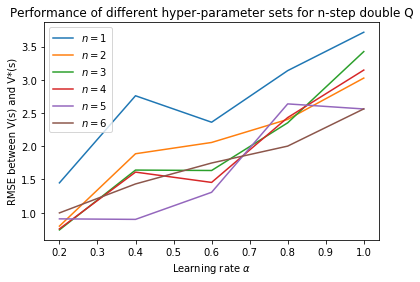

In [44]:
for n in n_list:
    rmse_curr = []
    for a in alpha_list:
        key = str(n)+"_"+str(a)
        V = avgDR0[key]["V"]
        rmse_curr.append((np.sqrt(np.mean(np.power(bellman_V - V,2)))))
    print(rmse_curr)
    plt.plot(alpha_list,rmse_curr,label=r'$n = $' + str(n))
plt.xlabel(r"Learning rate $\alpha$")
plt.ylabel("RMSE between V(s) and V*(s)")
plt.title(r"Performance of different hyper-parameter sets for n-step double Q")
plt.legend()
plt.show()


**Run nstep double weighted Q learning**

In [45]:
#init tables and hyper parameters to run n step double weighted Q
Q1 = np.zeros((7,3,4))
Q2 = np.zeros((7,3,4))
Q = np.zeros(Q1.shape)
env = EnvSetTarget(6,2)
num_episodes = 25000
gamma = 0.99
lamb = 0
alpha=0.2
epsilon=0.05
n=3
c = 1
double_weighted_Q_n_result_dict = {}
num_runs = 10
alpha_list = [x/10 for x in range(2,11,2)]
n_list = [x for x in range(1,7)]
c_list = [math.pow(10,x) for x in range(0,3)]

In [46]:
#run for different parameters and store the result in a dictionary
for c in c_list[:1]: # search through parameter c to manage weighted average
    for n in n_list[:1]: # search through n to balance between Monte Carlo and TD(0)
        for alpha in alpha_list[:1]: # search for appropriate learning rate
            for _ in range(num_runs):
                #print(c," ",n," ",alpha," ",_)
                Q1 = np.zeros((7,3,4))# init Q1
                Q2 = np.zeros((7,3,4)) # init Q2
                Q = np.zeros(Q1.shape)
                env = EnvSetTarget(6,2)
                # run 
                l=n_step_doubleweighted_Q_learning(env,num_episodes,Q1,Q2,alpha,epsilon,gamma,n,c)
                Q = (Q1+Q2)/2 # avg Q1 and Q2 to get Q
                V = np.max(Q,axis=2) # get V(s)
                double_weighted_Q_n_result_dict[str(n)+"_"+str(alpha)+"_"+str(c)+"_"+str(_)] = {"Q":deepcopy(Q),
                                                                "ret":l,"V":V}

In [47]:
#uncomment to store the results
import pickle
#pickle.dump(double_weighted_Q_n_result_dict,open("double_weighted_Q_n_result_dict_run.p","wb"))
#load results for double  weighted Q
DWR0 = pickle.load(open("double_weighted_Q_n_result_dict_run.p","rb"))

**Avg out the results for DWQ**

In [48]:
avgDWR0 = {} #dictionary to store the avg results
len(DWR0)
num_runs = 10

In [50]:
#avg the results through different runs
for c in c_list:
    for n in n_list:
        for alpha in alpha_list:
            avg_V = None
            avg_Q = None
            avg_l = None
            for run in range(num_runs):
                V = DWR0[str(n)+"_"+str(alpha)+"_"+str(c)+"_"+str(run)]["V"]
                RMSE = (np.sqrt(np.mean(np.power(bellman_V - V,2))))
                l = DWR0[str(n)+"_"+str(alpha)+"_"+str(c)+"_"+str(run)]["ret"]
                run_avg = np.cumsum(l)/(np.array(range(1,l.size+1)))
                Q = DWR0[str(n)+"_"+str(alpha)+"_"+str(c)+"_"+str(run)]["Q"]

                if type(avg_V) == type(None):
                    #print(n," ",alpha," ",run)
                    avg_V = 1/num_runs * V
                    avg_Q = 1/num_runs *Q
                    avg_l = 1/num_runs * run_avg
                else:
                    avg_V += 1/num_runs * V
                    avg_Q += 1/num_runs *Q
                    avg_l += 1/num_runs * run_avg


            avgDWR0[str(n) + "_" + str(alpha)+"_"+str(c)] = {"V":avg_V,"Q":avg_Q,"l":avg_l}
            #print(n," ",alpha," ",RMSE)



**Print the RMSE values for DWQ different hyper-parameter combinations**

In [52]:
for key in avgDWR0.keys():
    V = avgDWR0[key]["V"]
    RMSE = (np.sqrt(np.mean(np.power(bellman_V - V,2))))
    print("n,learning rate alpha,c, ",key," ",RMSE)

n,learning rate alpha,c,  1_0.2_1.0   1.34025220003
n,learning rate alpha,c,  1_0.4_1.0   1.72705817908
n,learning rate alpha,c,  1_0.6_1.0   2.49750102543
n,learning rate alpha,c,  1_0.8_1.0   2.3883309683
n,learning rate alpha,c,  1_1.0_1.0   3.04101972912
n,learning rate alpha,c,  2_0.2_1.0   1.2400383804
n,learning rate alpha,c,  2_0.4_1.0   1.37662592968
n,learning rate alpha,c,  2_0.6_1.0   1.94165025965
n,learning rate alpha,c,  2_0.8_1.0   2.58552087917
n,learning rate alpha,c,  2_1.0_1.0   2.7869272597
n,learning rate alpha,c,  3_0.2_1.0   0.717046575562
n,learning rate alpha,c,  3_0.4_1.0   1.46065506323
n,learning rate alpha,c,  3_0.6_1.0   2.20080645382
n,learning rate alpha,c,  3_0.8_1.0   1.51493307467
n,learning rate alpha,c,  3_1.0_1.0   2.91563723623
n,learning rate alpha,c,  4_0.2_1.0   1.03350226888
n,learning rate alpha,c,  4_0.4_1.0   1.52396176569
n,learning rate alpha,c,  4_0.6_1.0   1.40657689928
n,learning rate alpha,c,  4_0.8_1.0   2.06872429265
n,learning rat

**Storing the best perfomances for all methods and plotting the comparison**

In [ ]:
pickle.dump([R2["0.2_0.8"]["run_avg"], avgDR0["4_0.2"]["l"], avgDWR0["3_0.2_1.0"]["l"]],open("best all 3 plots.p","wb"))

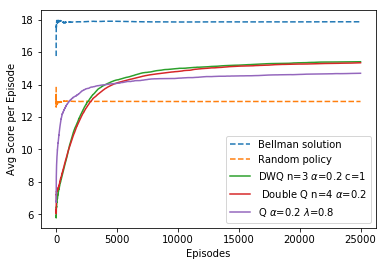

In [53]:
x = pickle.load(open("best all 3 plots.p","rb"))
b = pickle.load(open("bellman_performace_score.p","rb"))
r = pickle.load(open("random_performace_score.p","rb"))
b = np.cumsum(b)/(np.array(range(1,b.size+1)))
r = np.cumsum(r)/(np.array(range(1,r.size+1)))
#plt.errorbar([0,12000,24999],[17.88,17.88,17.88],yerr=2.49,label="Bellman solution",ls="--")
#plt.errorbar([0,12000,24999],[12.94,12.94,12.94],yerr=0.9,label="Random policy",ls="--")
plt.plot(range(b.size),b,label="Bellman solution",ls="--")
plt.plot(range(r.size),r,label="Random policy",ls="--")
plt.plot(range(x[2].size), x[2], label=r"DWQ n=3 $\alpha$=0.2 c=1")
plt.plot(range(x[1].size),x[1],label=r" Double Q n=4 $\alpha$=0.2")
plt.plot(range(x[0].size),x[0],label=r"Q $\alpha$=0.2 $\lambda$=0.8")
plt.xlabel("Episodes")
plt.ylabel("Avg Score per Episode")
plt.legend()
plt.show()